In [60]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [61]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [62]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

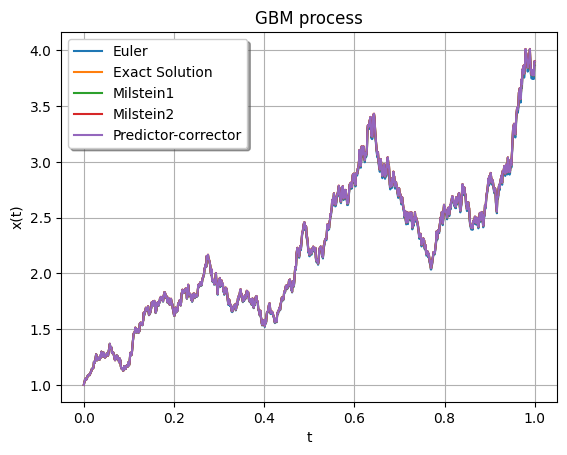

In [63]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


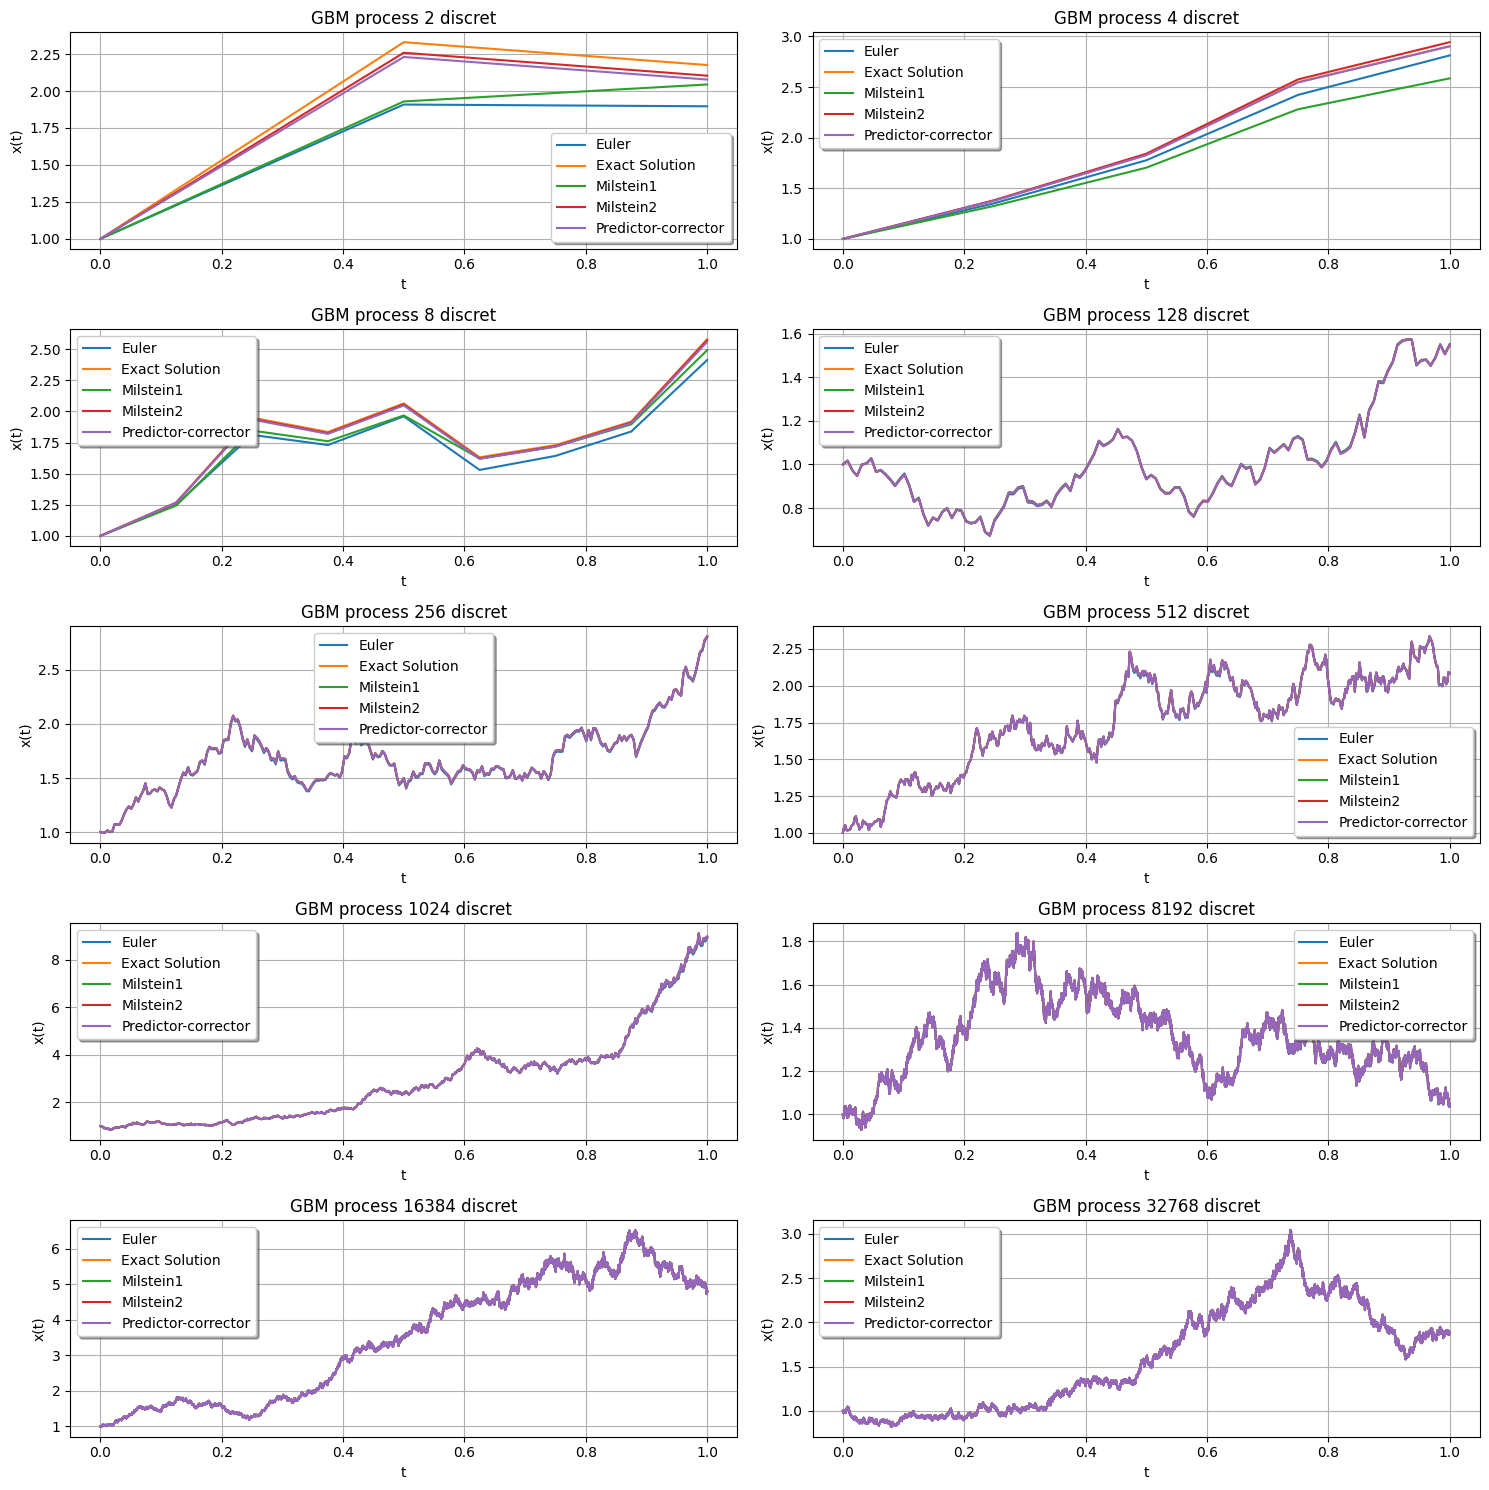

In [64]:
Nts = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

fig, axes = plt.subplots(len(Nts) // 2, len(Nts) // (len(Nts) // 2), figsize=(15, 15))

for i, Nt in enumerate(Nts):
  theta1 = 1
  theta2 = 1/2
  params = [theta1, theta2]

  dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


  BSMp = BSMprocess(params, T, Nx, Nt, init_state)
  t_data, x_data = BSMp.EulerSolution(dwt)
  axes[i // 2, i % 2].plot(t_data, x_data, label = 'Euler')

  t_data, x_data = BSMp.ExactSolution(dwt)
  axes[i // 2, i % 2].plot(t_data, x_data, label = 'Exact Solution')

  t_data, x_data = BSMp.Milstein1Solution(dwt)
  axes[i // 2, i % 2].plot(t_data, x_data, label = 'Milstein1')

  t_data, x_data = BSMp.Milstein2Solution(dwt)
  axes[i // 2, i % 2].plot(t_data, x_data, label = 'Milstein2')

  t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
  axes[i // 2, i % 2].plot(t_data, x_data, label = 'Predictor-corrector')

  axes[i // 2, i % 2].set_title(f"GBM process {Nt} discret")
  axes[i // 2, i % 2].legend(loc = 'best', fancybox = True, shadow = True)
  axes[i // 2, i % 2].set_xlabel("t")
  axes[i // 2, i % 2].set_ylabel("x(t)")
  axes[i // 2, i % 2].grid(True)

fig.tight_layout()
plt.show()

Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.

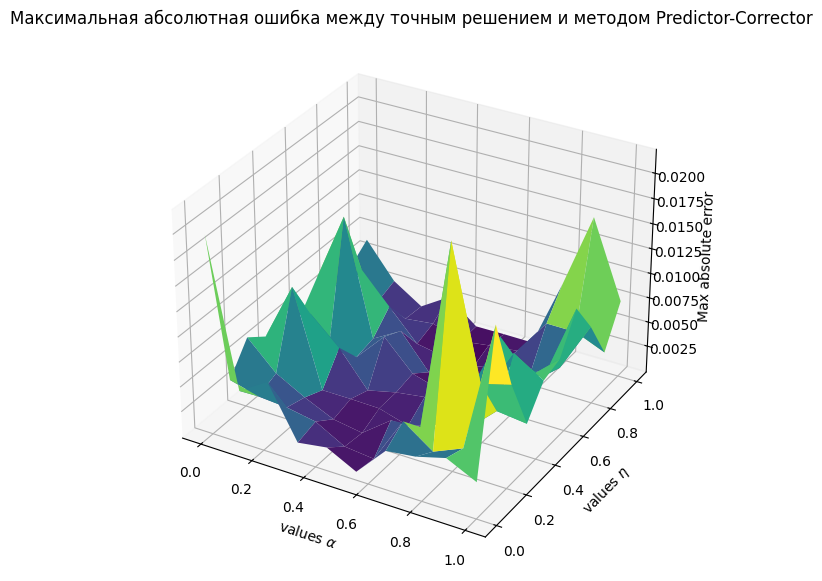

In [65]:
from joblib import Parallel, delayed

# Функция для расчета ошибки между точным решением и приближением predictor-corrector.
# alpha и eta — параметры метода predictor-corrector.
# N — количество шагов дискретизации, T — конечное время, params — параметры процесса, Nx — количество траекторий, init_state — начальное состояние.
def calculate_max_error(alpha, eta, steps, end_time, process_params, num_trajectories, start_state):
    # Генерация шумового процесса для броуновского движения
    dW_increment = np.random.normal(0, 1, size=(steps, num_trajectories)) * np.sqrt(end_time / steps)

    # Создание объекта процесса с заданными параметрами
    stochastic_process = BSMprocess(process_params, end_time, num_trajectories, steps, start_state)

    # Получение точного решения для процесса
    _, exact_trajectory = stochastic_process.ExactSolution(dW_increment)

    # Вычисление траектории по схеме predictor-corrector с заданными alpha и eta
    _, approx_trajectory = stochastic_process.PredictorCorrectorSolution(dW_increment, alpha, eta)

    # Расчет максимальной разницы между точным решением и приближением
    max_absolute_error = np.max(np.abs(exact_trajectory - approx_trajectory))

    return max_absolute_error


# Основные параметры для моделирования стохастического процесса
theta1 = 1        # Параметр сдвига
theta2 = 0.5      # Параметр волатильности
process_params = [theta1, theta2]
end_time = 1      # Временной интервал моделирования
num_trajectories = 1   # Число траекторий для моделирования
initial_state = np.array([1])  # Начальное состояние
steps = 1024 * 4       # Количество шагов дискретизации

# Задание диапазона значений параметров alpha и eta
alpha_range = np.linspace(0, 1, 10)
eta_range = np.linspace(0, 1, 10)

# Параллельный расчет ошибки для каждого сочетания параметров alpha и eta
# Используется Parallel для ускорения вычислений, results будет содержать ошибки для каждой комбинации параметров
errors_computed = Parallel(n_jobs=-1)(
    delayed(calculate_max_error)(alpha, eta, steps, end_time, process_params, num_trajectories, initial_state)
    for alpha in alpha_range for eta in eta_range
)

# Преобразование результата в двумерный массив для последующего построения графика
error_matrix = np.array(errors_computed).reshape(len(alpha_range), len(eta_range))

# Построение 3D-графика зависимости ошибки от значений alpha и eta
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Создание сетки значений для alpha и eta для корректного отображения данных на поверхности
alpha_grid, eta_grid = np.meshgrid(alpha_range, eta_range)
error_surface = error_matrix.T  # Транспонирование матрицы для корректного отображения

# Построение поверхности с использованием colormap 'viridis'
surface_plot = ax.plot_surface(alpha_grid, eta_grid, error_surface, cmap='viridis')

# Подписи к осям и заголовок графика для ясности
ax.set_xlabel(r'values $\alpha$')
ax.set_ylabel(r'values $\eta$')
ax.set_zlabel('Max absolute error')
plt.title('Максимальная абсолютная ошибка между точным решением и методом Predictor-Corrector')

plt.show()

Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

In [66]:
dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

IndexError: list index out of range

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

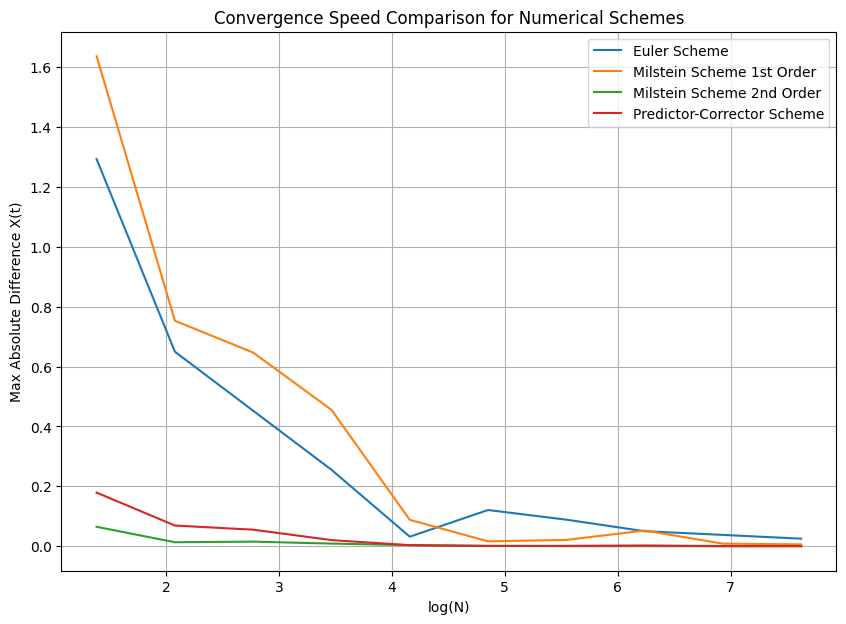

In [ ]:
# Функция для вычисления максимальной ошибки для заданного метода
def compute_error_for_scheme(scheme_func, exact_solution, dwt, params, T, Nx, Nt, init_state):
    # Инициализация процесса
    process = CIRprocess(params, T, Nx, Nt, init_state)
    _, x_exact = exact_solution(dwt)
    _, x_approx = scheme_func(dwt)
    max_error = np.max(np.abs(x_exact - x_approx))
    return max_error

# Параметры стохастического процесса
theta1 = 2
theta2 = 0.5
params = [theta1, theta2]
T = 1
Nx = 1
init_state = np.array([1])

# Диапазон значений N для дискретизации
N_values = [2**i for i in range(2, 12)]
log_N = np.log(N_values)

# Списки для хранения ошибок
errors_euler = []
errors_milstein1 = []
errors_milstein2 = []
errors_predictor_corrector = []

# Проход по каждому значению N и расчет ошибки для каждой схемы
for Nt in N_values:
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T / Nt)
    process = BSMprocess(params, T, Nx, Nt, init_state)
    
    # Точное решение
    _, exact_solution = process.ExactSolution(dwt)
    
    # Рассчитываем ошибки для каждой схемы
    errors_euler.append(compute_error_for_scheme(process.EulerSolution, process.ExactSolution, dwt, params, T, Nx, Nt, init_state))
    errors_milstein1.append(compute_error_for_scheme(process.Milstein1Solution, process.ExactSolution, dwt, params, T, Nx, Nt, init_state))
    errors_milstein2.append(compute_error_for_scheme(process.Milstein2Solution, process.ExactSolution, dwt, params, T, Nx, Nt, init_state))
    errors_predictor_corrector.append(compute_error_for_scheme(lambda dwt: process.PredictorCorrectorSolution(dwt, 1/2, 1/2), process.ExactSolution, dwt, params, T, Nx, Nt, init_state))

# Построение графиков сходимости для каждой схемы
plt.figure(figsize=(10, 7))
plt.plot(log_N, errors_euler, label='Euler Scheme')
plt.plot(log_N, errors_milstein1, label='Milstein Scheme 1st Order')
plt.plot(log_N, errors_milstein2, label='Milstein Scheme 2nd Order')
plt.plot(log_N, errors_predictor_corrector, label='Predictor-Corrector Scheme')
plt.xlabel('log(N)')
plt.ylabel('Max Absolute Difference X(t)')
plt.title('Convergence Speed Comparison for Numerical Schemes')
plt.legend()
plt.grid()
plt.show()


Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [ ]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

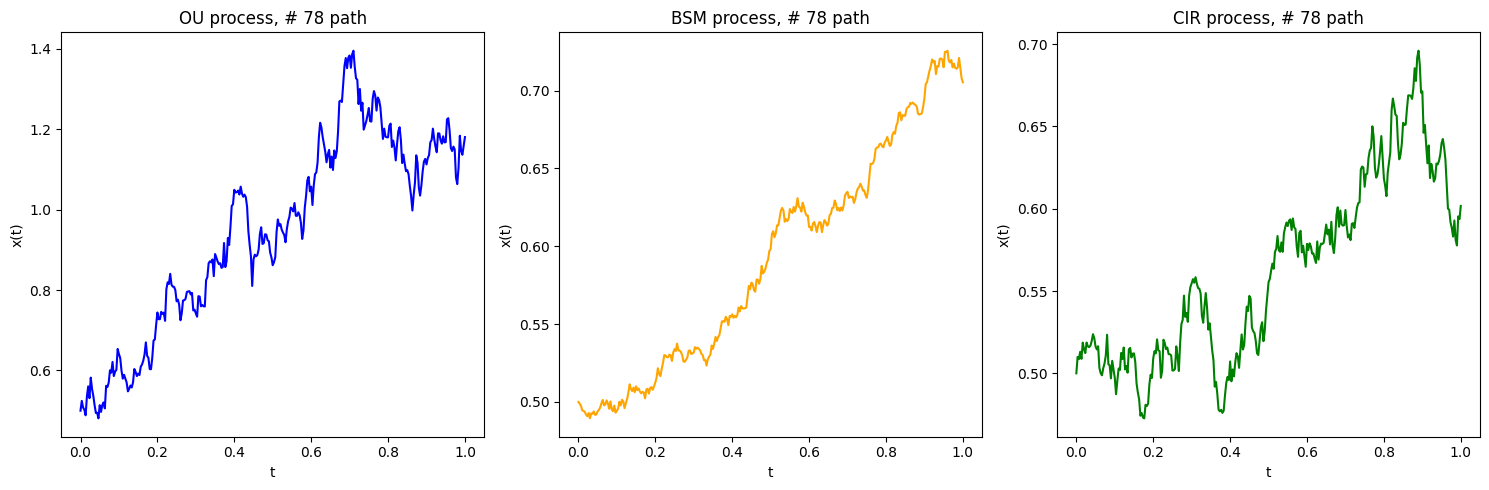

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

$$dX_t=\theta_1(X_t)^{-1}dt+\theta_2dW_t$$

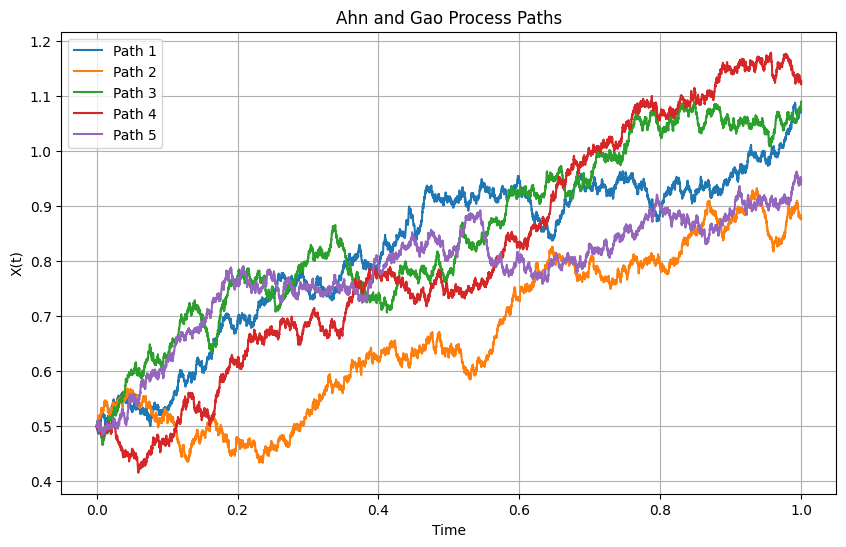

In [ ]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        """
        Инициализация модели Ахна и Гао.
        :param params: Параметры модели [theta1, theta2].
        :param T: Временной горизонт.
        :param Nx: Число траекторий.
        :param Nt: Число временных шагов.
        :param init_state: Начальное состояние X_0.
        """
        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] / np.maximum(x, 1e-6)  # Убеждаемся, что знаменатель не равен 0
        self.sigmaxt = lambda x: self.params[1]
    
    def DefaultInitState(self):
        """
        Начальное состояние для модели Ахна и Гао.
        """
        return np.ones(self.Nx) * (self.init_state if self.init_state is not None else 0.5)

    def SampleFromDensity(self, x0, t, t0):
        """
        Генерация нового состояния X_t, используя условное распределение.
        """
        dt = t - t0
        drift = self.bxt(x0) * dt
        diffusion = self.sigmaxt(x0) * np.random.normal(0, np.sqrt(dt), size=self.Nx)
        return x0 + drift + diffusion

    def PathGenerator(self):
        """
        Генератор траекторий процесса Ахна и Гао.
        """
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        # Установка начального состояния
        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        # Генерация траекторий
        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        
        return t_data, x_data

# Пример использования нового класса для генерации пути
T = 1          # Временной горизонт
Nx = 5         # Количество траекторий
Nt = 1024 * 8      # Количество временных шагов
theta1 = 0.5   # Параметр дрейфа
theta2 = 0.2   # Параметр волатильности
params = [theta1, theta2]
init_state = 0.5  # Начальное состояние

# Создание объекта модели Ахна и Гао и генерация траекторий
ahn_gao_process = AhnGaoProcess(params, T, Nx, Nt, init_state=init_state)
t_data, paths = ahn_gao_process.PathGenerator()

# Визуализация нескольких траекторий процесса Ахна и Гао
plt.figure(figsize=(10, 6))
for i in range(Nx):
    plt.plot(t_data, paths[:, i], label=f'Path {i+1}')
plt.title("Ahn and Gao Process Paths")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

90%-ный квантиль: 1.3238322232166857


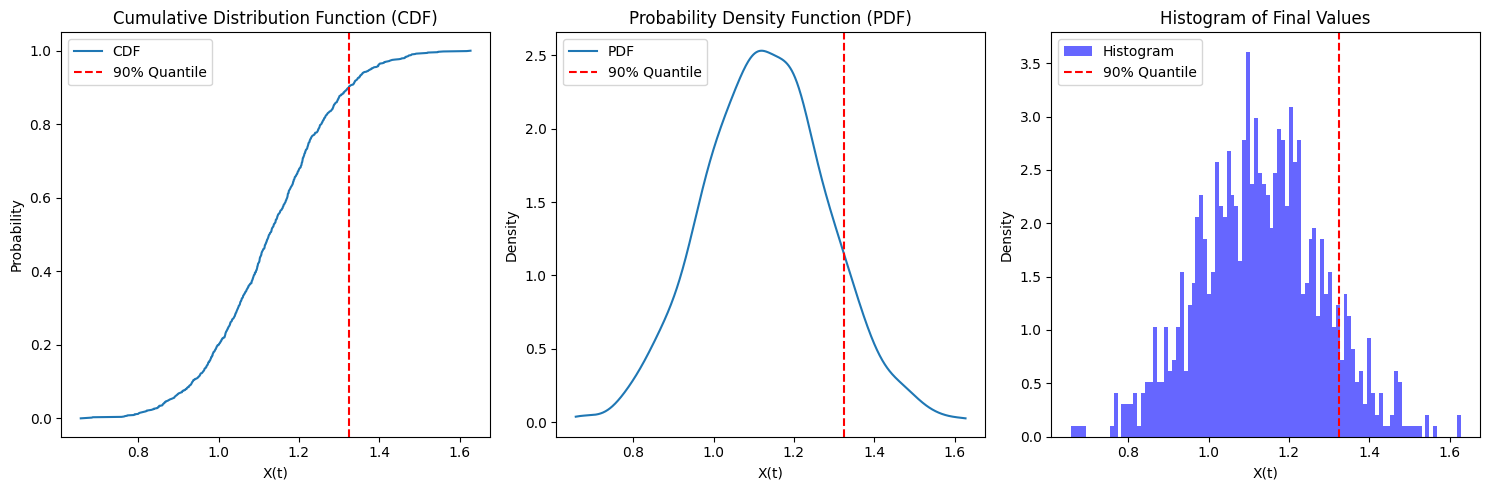

In [ ]:
from scipy.stats import gaussian_kde

# Параметры процесса Ахна и Гао
T = 1          # Временной горизонт
Nx = 1000      # Количество траекторий для статистической значимости
Nt = 10000      # Количество временных шагов
theta1 = 0.5   # Параметр дрейфа
theta2 = 0.2   # Параметр волатильности
params = [theta1, theta2]
init_state = 0.5  # Начальное состояние

# Генерация траекторий
ahn_gao_process = AhnGaoProcess(params, T, Nx, Nt, init_state=init_state)
t_data, paths = ahn_gao_process.PathGenerator()

# Берем значения X(t) на последнем шаге времени для анализа
final_values = paths[-1, :]

# Расчет 90%-ного квантили
quantile_90 = np.quantile(final_values, 0.9)
print(f"90%-ный квантиль: {quantile_90}")

# Построение CDF
sorted_values = np.sort(final_values)
cdf = np.linspace(0, 1, len(sorted_values))

plt.figure(figsize=(15, 5))

# График CDF
plt.subplot(1, 3, 1)
plt.plot(sorted_values, cdf, label="CDF")
plt.axvline(quantile_90, color='r', linestyle='--', label="90% Quantile")
plt.title("Cumulative Distribution Function (CDF)")
plt.xlabel("X(t)")
plt.ylabel("Probability")
plt.legend()

# График PDF
plt.subplot(1, 3, 2)
kde = gaussian_kde(final_values)
x_pdf = np.linspace(min(final_values), max(final_values), 1000)
pdf_values = kde(x_pdf)
plt.plot(x_pdf, pdf_values, label="PDF")
plt.axvline(quantile_90, color='r', linestyle='--', label="90% Quantile")
plt.title("Probability Density Function (PDF)")
plt.xlabel("X(t)")
plt.ylabel("Density")
plt.legend()

# Гистограмма значений для наглядности
plt.subplot(1, 3, 3)
plt.hist(final_values, bins=100, density=True, alpha=0.6, color='b', label="Histogram")
plt.axvline(quantile_90, color='r', linestyle='--', label="90% Quantile")
plt.title("Histogram of Final Values")
plt.xlabel("X(t)")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

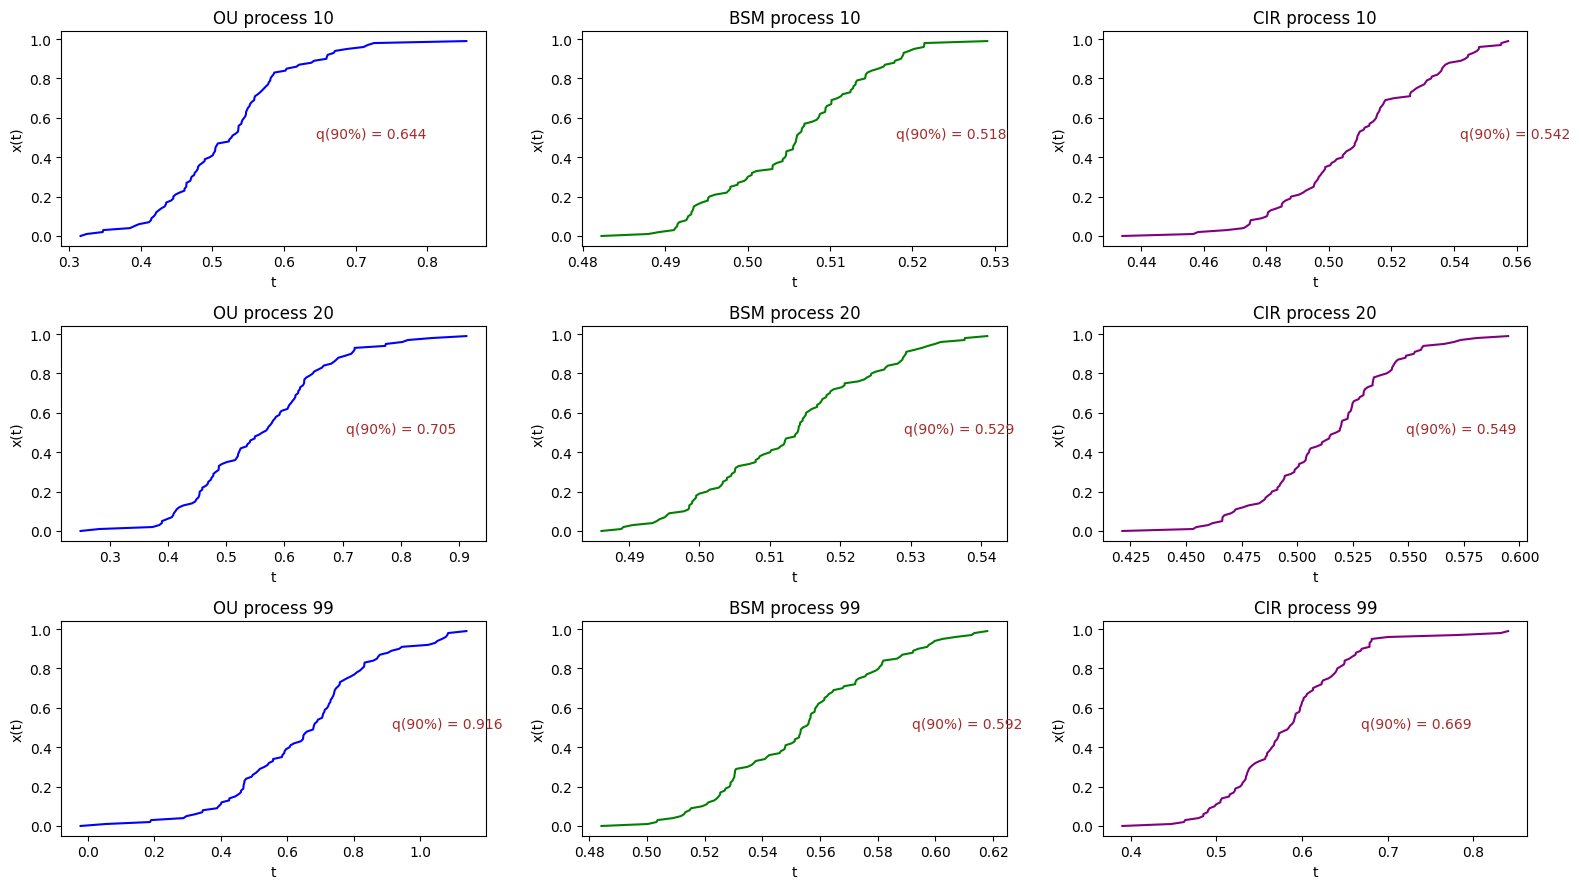

In [94]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y


#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = n * 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = x_data_CIR.shape[1] - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

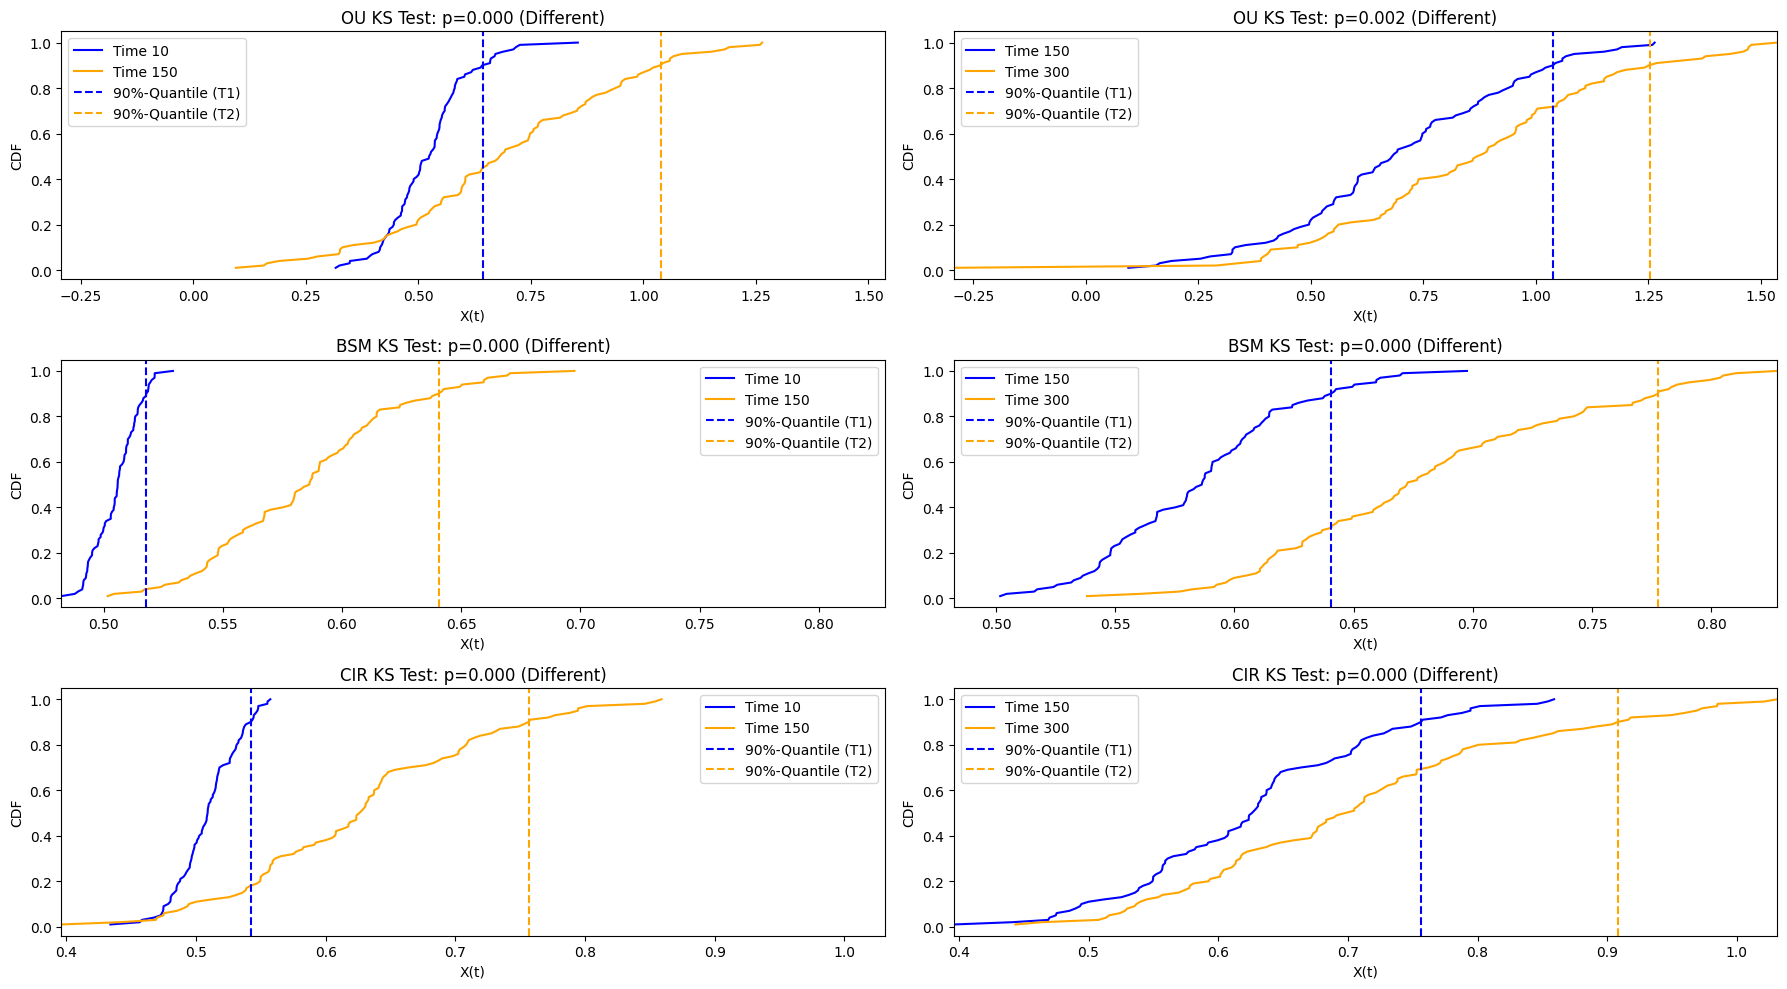

In [99]:
from scipy.stats import ks_2samp

# Корректные временные индексы, основанные на размере данных для процессов
time_indices = [10, len(x_data_OU) // 2, len(x_data_OU) - 1]

# Подразумевается, что x_data_OU, x_data_BSM, x_data_CIR содержат данные
processes = {
    "OU": x_data_OU,
    "BSM": x_data_BSM,
    "CIR": x_data_CIR
}

fig, axs = plt.subplots(3, 2, figsize=(18, 10))
for row, (process_name, x_data) in enumerate(processes.items()):
    # Устанавливаем диапазон по X для данного процесса
    x_min = min(min(x_data[idx]) for idx in time_indices)
    x_max = max(max(x_data[idx]) for idx in time_indices)

    for col in range(len(time_indices) - 1):
        # Данные для двух временных отрезков
        sample1 = x_data[time_indices[col]]
        sample2 = x_data[time_indices[col + 1]]
        
        # Рассчитываем ECDF для каждого временного отрезка
        ecdf1 = ECDF(sample1)
        ecdf2 = ECDF(sample2)
        
        # 90%-квантиль для выборок
        quantile1 = np.quantile(sample1, 0.9)
        quantile2 = np.quantile(sample2, 0.9)
        
        # Статистика Колмогорова-Смирнова
        ks_stat, p_value = ks_2samp(sample1, sample2)
        conclusion = "Different" if p_value < 0.05 else "Same"

        # Параметры графика
        ax = axs[row, col]
        ax.plot(ecdf1.x, ecdf1.y, label=f"Time {time_indices[col]}", color="blue")
        ax.plot(ecdf2.x, ecdf2.y, label=f"Time {time_indices[col + 1]}", color="orange")
        
        # Добавляем линии 90%-квантиля
        ax.axvline(quantile1, color='blue', linestyle="--", label="90%-Quantile (T1)")
        ax.axvline(quantile2, color='orange', linestyle="--", label="90%-Quantile (T2)")
        
        # Устанавливаем одинаковый диапазон по X для всех графиков одного процесса
        ax.set_xlim(x_min, x_max)
        
        # Заголовок и информация о тесте
        ax.set_title(f"{process_name} KS Test: p={p_value:.3f} ({conclusion})")
        ax.set_xlabel("X(t)")
        ax.set_ylabel("CDF")
        ax.legend()

# Корректировка общего внешнего вида
plt.tight_layout()
plt.show()

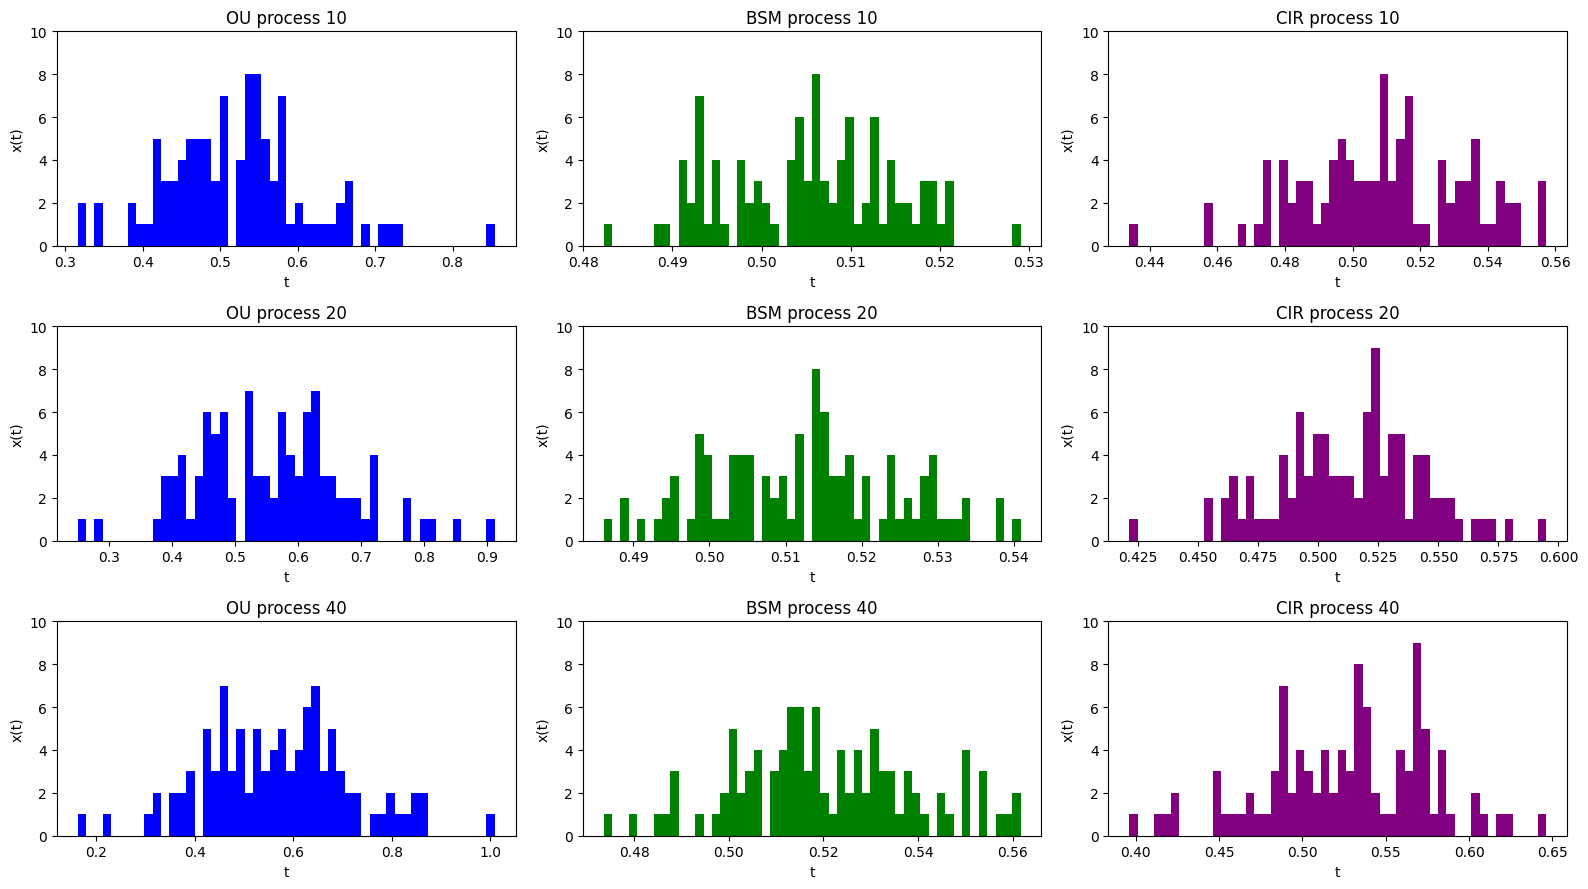

In [105]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue', bins=50)
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green', bins=50)
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple', bins=50)
axs[0][2].set_title(f'CIR process {n}')

n = n * 2
axs[1][0].hist(x_data_OU[n], color='blue', bins=50)
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green', bins=50)
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple', bins=50)
axs[1][2].set_title(f'CIR process {n}')

n = n * 2
axs[2][0].hist(x_data_OU[n], color='blue', bins=50)
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green', bins=50)
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple', bins=50)
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 10)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

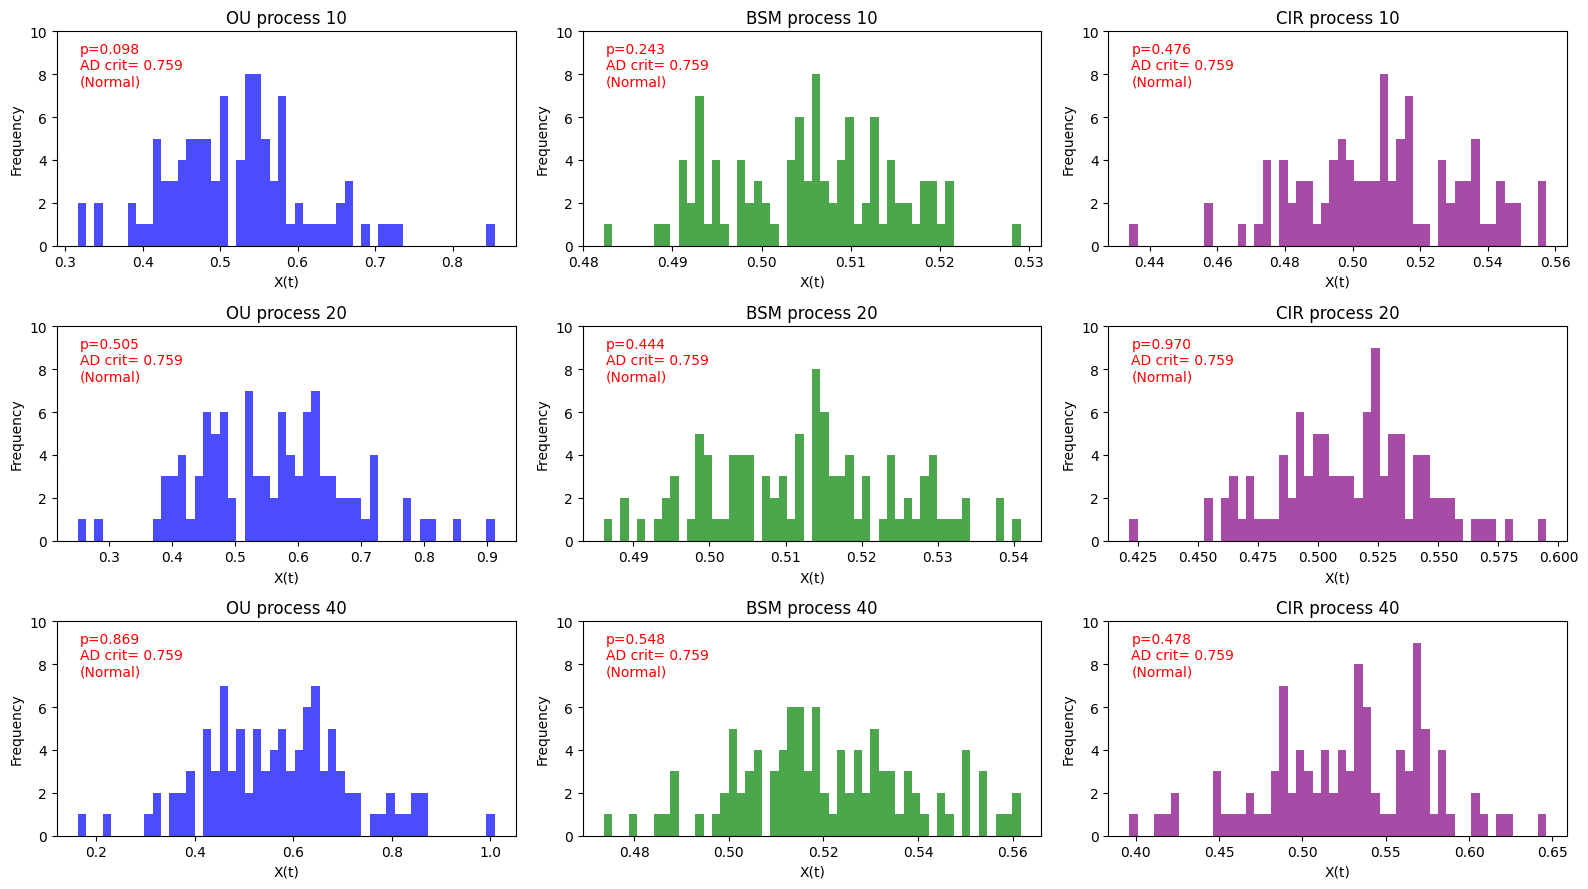

In [109]:
from scipy.stats import shapiro, anderson

# Подразумевается, что x_data_OU, x_data_BSM, x_data_CIR содержат данные
fig, axs = plt.subplots(3, 3, figsize=(16, 9))

# Временные индексы
n_values = [10, 20, 40]

# Создаем гистограммы и проводим тест на нормальность
for i, n in enumerate(n_values):
    # Орнштейн-Уленбек процесс
    axs[i][0].hist(x_data_OU[n], color='blue', bins=50, alpha=0.7)
    axs[i][0].set_title(f'OU process {n}')
    # Тест Шапиро-Уилка
    stat, p_value = shapiro(x_data_OU[n])
    # Тест Андерсона-Дарлинга
    ad_result = anderson(x_data_OU[n])
    critical_value = ad_result.critical_values[2]  # Берем критическое значение для 5% уровня
    conclusion = "Normal" if p_value > 0.05 else "Not Normal"
    # Вывод p-value и критического значения
    axs[i][0].text(0.05, 0.95, f'p={p_value:.3f}\nAD crit= {critical_value:.3f}\n({conclusion})', 
                   color="red", ha='left', va='top', transform=axs[i][0].transAxes)

    # Геометрическое броуновское движение
    axs[i][1].hist(x_data_BSM[n], color='green', bins=50, alpha=0.7)
    axs[i][1].set_title(f'BSM process {n}')
    # Тест Шапиро-Уилка
    stat, p_value = shapiro(x_data_BSM[n])
    # Тест Андерсона-Дарлинга
    ad_result = anderson(x_data_BSM[n])
    critical_value = ad_result.critical_values[2]  # Берем критическое значение для 5% уровня
    conclusion = "Normal" if p_value > 0.05 else "Not Normal"
    # Вывод p-value и критического значения
    axs[i][1].text(0.05, 0.95, f'p={p_value:.3f}\nAD crit= {critical_value:.3f}\n({conclusion})', 
                   color="red", ha='left', va='top', transform=axs[i][1].transAxes)

    # Кокс-Ингерсолл-Росс процесс
    axs[i][2].hist(x_data_CIR[n], color='purple', bins=50, alpha=0.7)
    axs[i][2].set_title(f'CIR process {n}')
    # Тест Шапиро-Уилка
    stat, p_value = shapiro(x_data_CIR[n])
    # Тест Андерсона-Дарлинга
    ad_result = anderson(x_data_CIR[n])
    critical_value = ad_result.critical_values[2]  # Берем критическое значение для 5% уровня
    conclusion = "Normal" if p_value > 0.05 else "Not Normal"
    # Вывод p-value и критического значения
    axs[i][2].text(0.05, 0.95, f'p={p_value:.3f}\nAD crit= {critical_value:.3f}\n({conclusion})', 
                   color="red", ha='left', va='top', transform=axs[i][2].transAxes)

# Настройки осей и меток
for k in range(3):
    for j in range(3):
        axs[k][j].set_ylim(0, 10)
        axs[k][j].set_xlabel('X(t)')
        axs[k][j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()